# Creating Graph

In [1]:
import os
import h5py
from sklearn.neighbors import NearestNeighbors
import numpy as np   
import ipyvolume as ipv
import time

import sys
sys.path.append("..") 
from cryoem.plots import plot_projection, plot_projections
from cryoem.projections import RotationMatrix

## Read generated data

Data was generated with:
```
python generator.py -mrc generated_data/bgal.mrc -num 5000
```

In [2]:
# location of *.h5 files
data_dir = "../generated_data"

# half coverage (AngCoverage=0.5)
projections_filename = "ProjectionsAngles_ProjNber5000_AngCoverage0.5_AngShift1.57"

# load structures
data = h5py.File(os.path.join(data_dir, f"{projections_filename}.h5"), 'r')

## Add Gauss Noise to Projections

<div class="alert alert-warning" style="max-width: 20rem;">
  <h4 class="alert-heading">Add Noise</h4>
  <p class="mb-0">We start by adding Gaussian noise with variance=15, mean=0 in order to simulate the input data we will get to our pipeline.</p>
</div>

In [3]:
from cryoem.noise import gaussian_noise

In [4]:
projections = np.zeros(data["Projections"].shape)

In [5]:
var = 100

In [6]:
for datapoint in range(len(data["Projections"])):
    projections[datapoint] = data["Projections"][datapoint] + gaussian_noise(data["Projections"][datapoint].shape, mean=0, var=var)

## k-NN on **projections**

In [7]:
projections.shape

(5000, 136, 136)

In [8]:
X = np.reshape(projections, (projections.shape[0], -1))
X.shape

(5000, 18496)

In [9]:
start_time = time.time()

if not os.path.exists(f'data/{projections_filename}_WithGaussNoise{var}_distances.npy'):
    nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    connections = nbrs.kneighbors_graph(X).toarray()
    
    np.save(f'data/{projections_filename}_WithGaussNoise{var}_indices', indices)         # Indices of the nearest points in the population matrix
    np.save(f'data/{projections_filename}_WithGaussNoise{var}_distances', distances)     # Array representing the lengths to points
    np.save(f'data/{projections_filename}_WithGaussNoise{var}_connections', connections) # Sparse graph showing the connections between neighboring points
    
else:
    indices     = np.load(f'data/{projections_filename}_WithGaussNoise{var}_indices.npy')     # shape: NUM_IMGS, NUM_NEIGHBOURS
    distances   = np.load(f'data/{projections_filename}_WithGaussNoise{var}_distances.npy')   # shape: NUM_IMGS, NUM_NEIGHBOURS
    connections = np.load(f'data/{projections_filename}_WithGaussNoise{var}_connections.npy') # shape: NUM_IMGS, NUM_IMGS
    
print(f"--- {time.time() - start_time} seconds ---")

--- 1068.9810180664062 seconds ---


In [10]:
connections.shape

(5000, 5000)

In [11]:
indices[0]

array([   0, 4733, 4304,  908, 4540])

In [12]:
distances[0]

array([   0.        , 1901.01560136, 1904.1077253 , 1904.75301682,
       1905.97794576])

### Plot similar projections

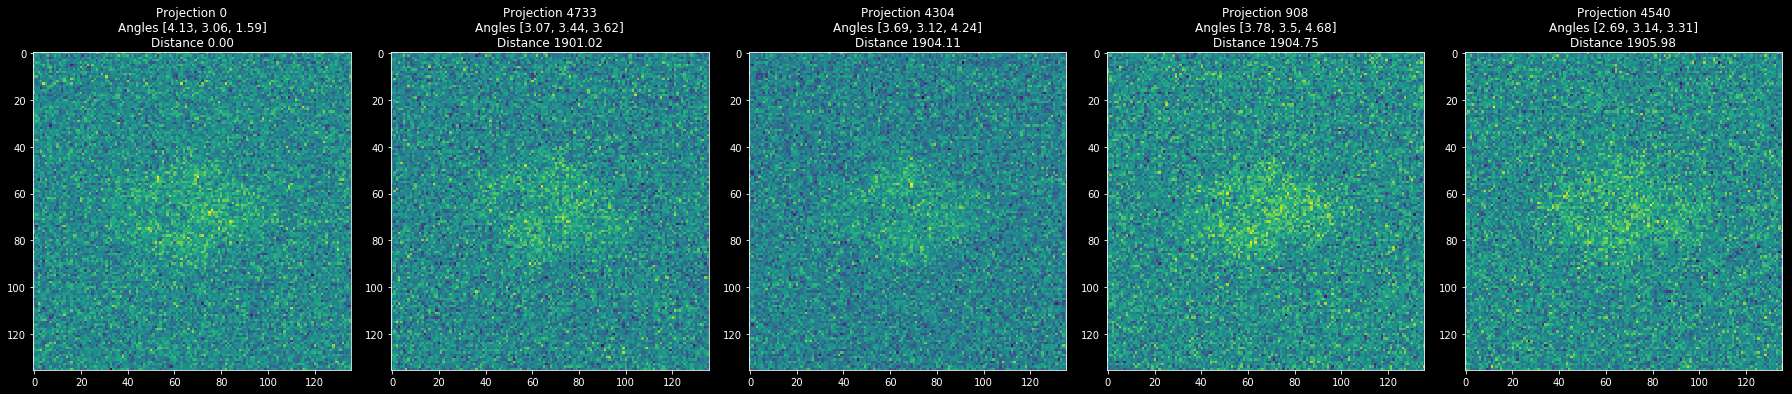

In [13]:
indices1 = indices[0]
distances1 = distances[0]

nrows, ncols = 1, 5
start_row, start_col = 0, 0

images = []
titles = []

cr = [(i, j) for i in range(nrows) for j in range(ncols)]

for datapoint, distance in zip(indices1, distances1):
    image = projections[datapoint]
    image = image #+ gaussian_noise(shape=image.shape, mean=0, var=0)

    angles = [ float(f"{x:.2f}") for x in data["Angles"][datapoint] ]
    title = f'Projection {datapoint}\nAngles {angles}\nDistance {distance:.2f}'
    
    images.append(image)
    titles.append(title)
        
plot_projections(images, titles, nrows=nrows, ncols=ncols)

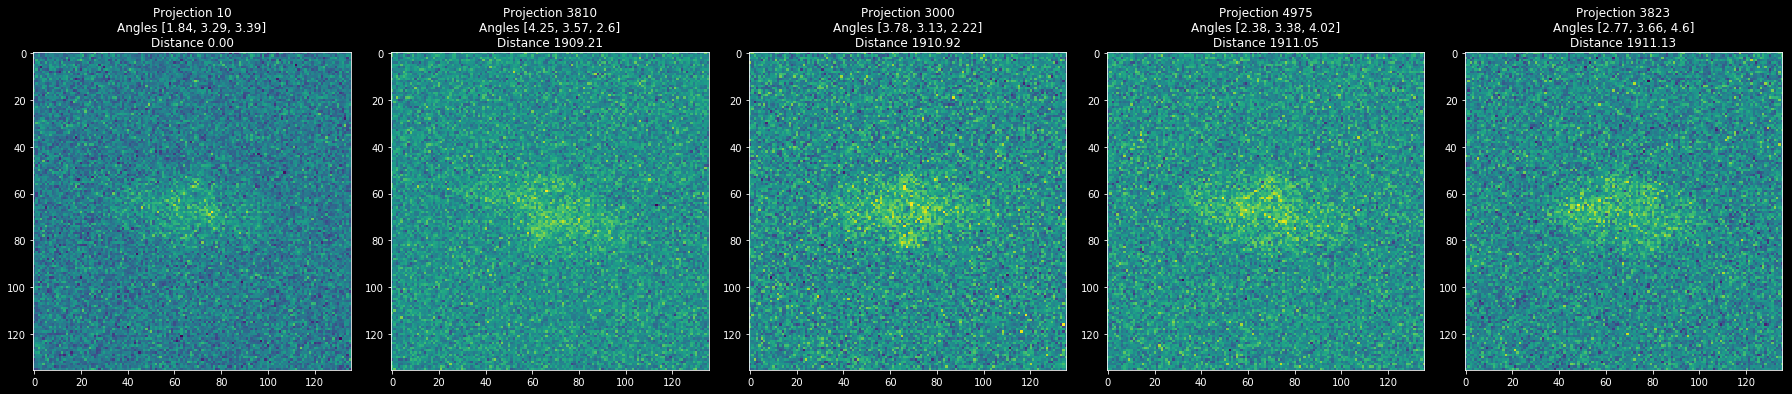

In [14]:
indices1 = indices[10]
distances1 = distances[10]

nrows, ncols = 1, 5
start_row, start_col = 0, 0

images = []
titles = []

cr = [(i, j) for i in range(nrows) for j in range(ncols)]

for datapoint, distance in zip(indices1, distances1):
    image = projections[datapoint]
    image = image #+ gaussian_noise(shape=image.shape, mean=0, var=0)

    angles = [ float(f"{x:.2f}") for x in data["Angles"][datapoint] ]
    title = f'Projection {datapoint}\nAngles {angles}\nDistance {distance:.2f}'
    
    images.append(image)
    titles.append(title)
        
plot_projections(images, titles, nrows=nrows, ncols=ncols)

##### Debug angles

In [15]:
data["Angles"][0]

array([4.13407857, 3.05641533, 1.59217456])

In [16]:
min(data["Angles"][:, 0]), max(data["Angles"][:, 0]), np.pi/2, 2*np.pi - np.pi/2

(1.5714457049679338, 4.711916156789442, 1.5707963267948966, 4.71238898038469)

#### Without Rotation Matrix

In [40]:
indices1 = indices[1]

knn_vectors = np.take(data["Angles"], indices1, axis=0)
all_vectors = np.delete(data["Angles"], indices1, 0)

ipv.figure(width=500, height=400)
ipv.scatter(knn_vectors[:,0], knn_vectors[:,2], knn_vectors[:,1], marker="diamond", color="red", size=1.5)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.show()

#### With Rotation Matrix

In [43]:
indices1 = indices[1000]

knn_vectors = RotationMatrix(np.take(data["Angles"], indices1, axis=0))
all_vectors = RotationMatrix(np.delete(data["Angles"], indices1, 0))

print(all_vectors.shape)
print(all_vectors[0])

ipv.figure(width=500, height=400)
ipv.scatter(knn_vectors[:,0], knn_vectors[:,2], knn_vectors[:,1], marker="diamond", color="red", size=1.5)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.show()

(4995, 12)
[ 0.08505492 -0.56240424 -0.82247622  0.          0.          0.
 -0.9963746  -0.04650249 -0.0712402   0.0018186   0.82555375 -0.56432057]


---

# Quaternions

Visualizing **SO(3) space**. Following explaination in [wiki](https://en.wikipedia.org/wiki/3D_rotation_group#Topology).

How to use [pyquaternions](http://kieranwynn.github.io/pyquaternion/).


In [19]:
from pyquaternion import Quaternion

## One Quaternion

In [20]:
angle1 = data["Angles"][0]
angle1

array([4.13407857, 3.05641533, 1.59217456])

In [21]:
qx = Quaternion(axis=[1, 0, 0], angle=angle1[0])
qy = Quaternion(axis=[0, 1, 0], angle=angle1[1])
qz = Quaternion(axis=[0, 0, 1], angle=angle1[2])

In [22]:
# compose rotations above
q = qx*qy*qz
q.axis, q.angle

(array([-0.40923767, -0.46891696,  0.78271413]), -1.7472933089540774)

In [23]:
point = list(map(lambda x: np.array([x * q.angle]), q.axis))
point

[array([0.71505825]), array([0.81933546]), array([-1.36763117])]

## All Quaternions

In [24]:
def quaternion(angle):
    """
    Quaternion implements 3 rotations along x, y, z axis. 
    We compose them to get the final (single) rotation.
    """
    qx = Quaternion(axis=[1, 0, 0], angle=angle[0])
    qy = Quaternion(axis=[0, 1, 0], angle=angle[1])
    qz = Quaternion(axis=[0, 0, 1], angle=angle[2])
    
    # compose rotations above
    q = qx*qy*qz

    return q

In [25]:
def quaternion2point(q):
    """ Convert Quaternion to point
    
    We convert Qaternion to the point described with x, y, z values in the Cartesian coordinate system.
    From the Qaternion we get axis and angle. The axis is described as unit vector (ux, uy, uz) and the angle is magnitude of vector.
    Using this two information, we can get the x, y, z coordinates of the point described with axis and angle.
    """
    point = np.array(list(map(lambda x: x * q.angle, q.axis)))
    return point

In [26]:
points1 = np.zeros(data["Angles"].shape)

for idx, angles in enumerate(data["Angles"]):
    point = quaternion2point(quaternion(angles))
    points1[idx, :] = point

points1

array([[ 0.71505825,  0.81933546, -1.36763117],
       [ 1.19184442,  0.91826144,  1.18319472],
       [-0.56564315, -0.84362882,  0.19120245],
       ...,
       [-0.98033571, -0.19442877,  0.99015664],
       [ 0.03581672,  0.25201743, -1.12710559],
       [-0.78496736,  0.51626461, -1.4336596 ]])

In [27]:
ipv.figure(width=500, height=400)
ipv.scatter(points1[:, 0], points1[:, 1], points1[:, 2], marker="sphere", color="blue", size=1.5)
ipv.show()

##### Debug the SO(3) space

In [28]:
max(points1[:,0]), min(points1[:,0])

(2.0994044630378466, -2.1805006731730128)

---

# kNN results in the SO(3)

## Half coverage angles

For kNN calculated on the half coverage angles, we have the following output of the kNN that was estimated on those projections.

In [29]:
indices1 = indices[10]

knn_vectors = np.take(points1, indices1, axis=0)
all_vectors = np.delete(points1, indices1, 0)

ipv.figure(width=500, height=400)
ipv.scatter(knn_vectors[:,0], knn_vectors[:,2], knn_vectors[:,1], marker="diamond", color="red", size=1.5)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.show()

# Graph visualization

You can use the [PyGSP](https://github.com/epfl-lts2/pygsp) (a python package developed by our lab) to
look at it like a graph. 

Install with: 
```
pip install git+https://github.com/epfl-lts2/pygsp@naspert-nn_refactor. 
```

Then build the graph with graph = pygsp.graphs.Graph(adjacency, coords=embedding),
where adjacency is the kNN matrix, i.e., adjacency[i, j] is the
similarity between nodes i and j  
(you can make it binary, that is **=1** if
node j is one of the k nearest neighbors of node i, **=0** otherwise), and
embedding[i] is the coordinate of node i in that 3D space.

You can also build the kNN graph directly with the PyGSP as graph =
pygsp.graphs.NNGraph(X), where X is the images in pixel space. That is,
the same matrix you're passing to sklearn.neighbors.NearestNeighbors.
Then set the 3D coordinates with graph.coords = embedding. Ideally, we
should integrate sklearn as another backend and allow NNGraph to accept
a custom distance function.

Doing the above should give you intuitions about a graph embedded in SO(3).

In [30]:
np.fill_diagonal(connections, 0)

In [31]:
indices

array([[   0, 4733, 4304,  908, 4540],
       [   1, 2037,  385,  568, 2540],
       [   2, 2873, 1662,  461, 1352],
       ...,
       [4997, 1429, 2690, 1971,  494],
       [4998, 1047, 3558, 2779, 1741],
       [4999, 1169, 2820, 1690, 1287]])

In [32]:
distances

array([[   0.        , 1901.01560136, 1904.1077253 , 1904.75301682,
        1905.97794576],
       [   0.        , 1907.01467932, 1907.12927281, 1907.47734015,
        1908.22130544],
       [   0.        , 1891.14577532, 1896.31087446, 1896.49719247,
        1897.40411636],
       ...,
       [   0.        , 1909.16870859, 1915.46346446, 1915.7126964 ,
        1916.25762392],
       [   0.        , 1903.06246658, 1907.96675796, 1908.77541117,
        1910.65292111],
       [   0.        , 1895.51805169, 1907.57319013, 1911.01822154,
        1911.15063519]])

In [33]:
connections

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
import pygsp

Adjacency shape: (5000, 5000)
Embedding shape: (5000, 3)


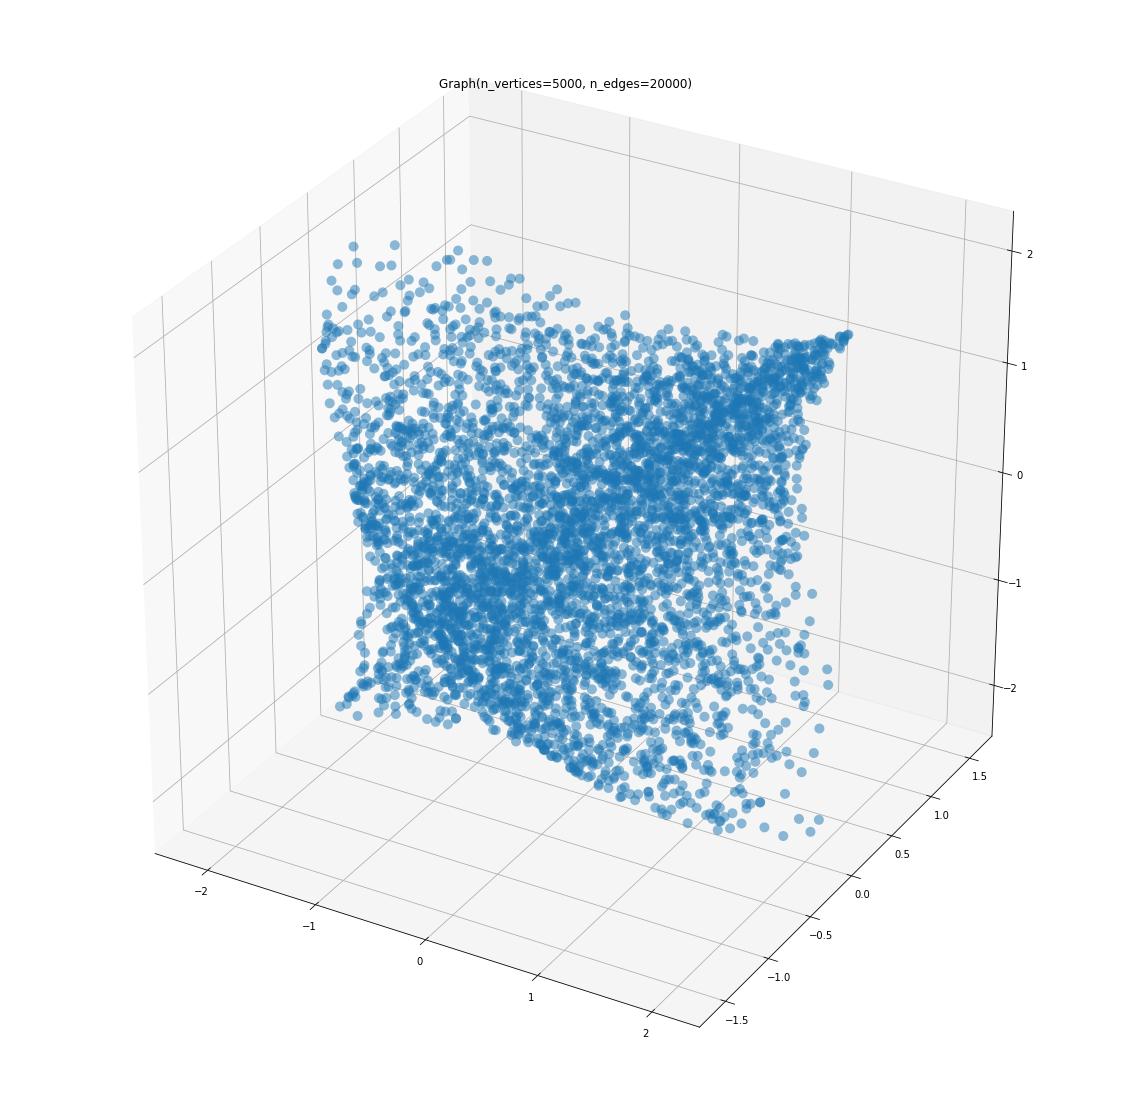

In [35]:
adjacency = connections  # kNN matrix, 1 if nodes i and j are neighbours, 0 othervise
embedding = points1      # SO(3) space coordinates

print(f"Adjacency shape: {adjacency.shape}")
print(f"Embedding shape: {embedding.shape}")

graph = pygsp.graphs.Graph(adjacency, coords=embedding)
fig, ax = graph.plot(edge_width=2, edge_color='black')
fig.set_figwidth(20)
fig.set_figheight(20)

Adjacency shape: (5000, 5000)
Embedding shape: (5000, 3)


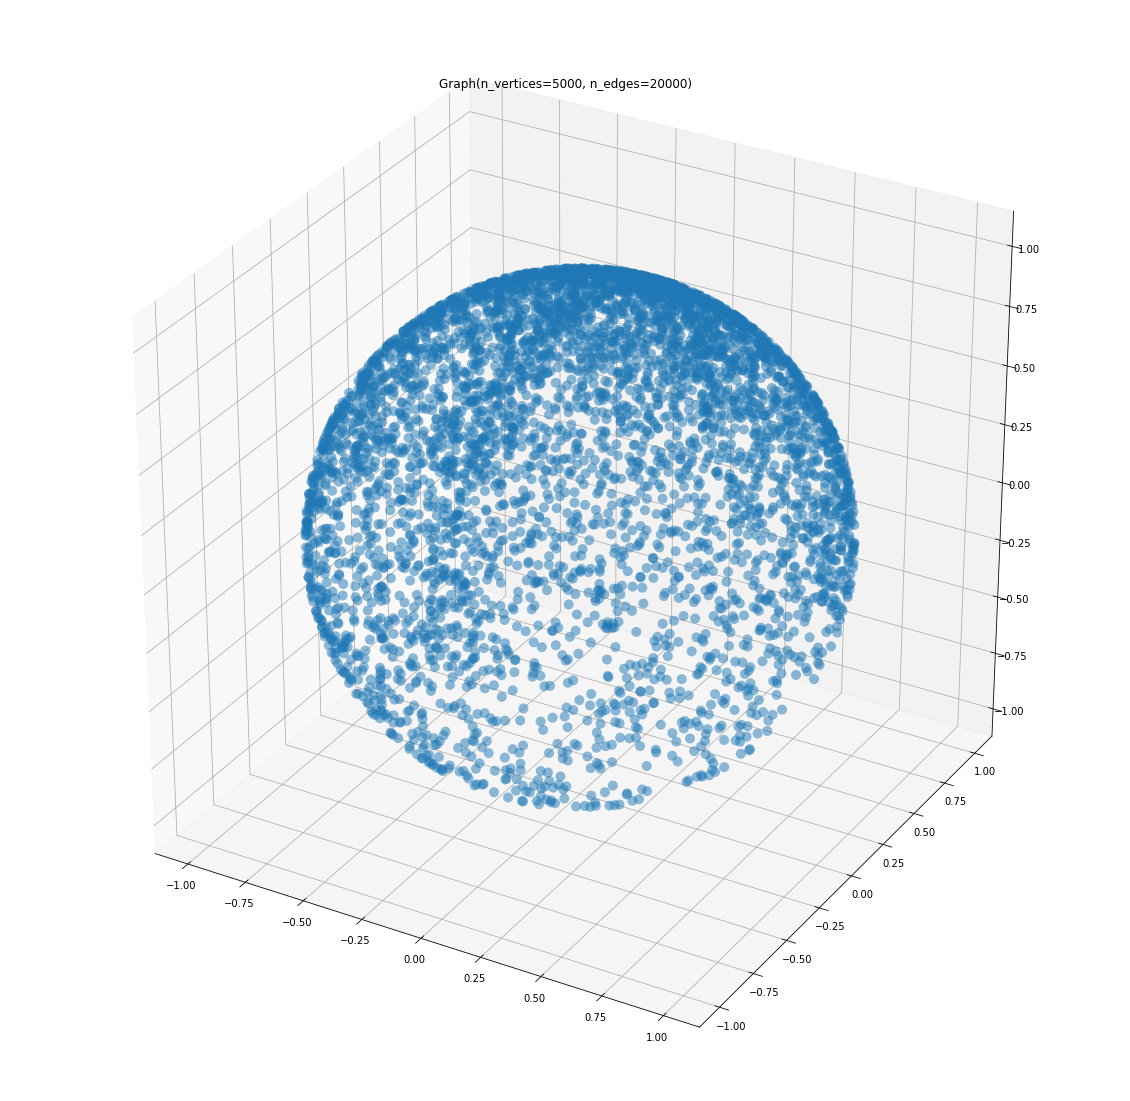

In [36]:
adjacency = connections  # kNN matrix, 1 if nodes i and j are neighbours, 0 othervise
embedding = RotationMatrix(data["Angles"])[:,0:3] #points1 

print(f"Adjacency shape: {adjacency.shape}")
print(f"Embedding shape: {embedding.shape}")

graph = pygsp.graphs.Graph(adjacency, coords=embedding)
fig, ax = graph.plot(edge_width=20, edge_color='black')
fig.set_figwidth(20)
fig.set_figheight(20)

---